# Non-zero starting and ending velocities

TOPP-RA can also parametrize geometric paths that respect initial and final velocity:
\[
  \dot{\mathbf q}(0) = \mathbf p'(0) * 0.2 \\
  \dot{\mathbf q}(T_{final}) = \mathbf p'(1) * 0.2
\]

In [49]:
# toppra
import toppra as ta
import toppra.constraint as constraint
import toppra.algorithm as algo
import numpy as np
# misc: for plotting and measuring time
import matplotlib.pyplot as plt
import time

ta.setup_logging()

# Random waypoints used to obtain a random geometric path. Here,
# we use spline interpolation.
dof = 6
np.random.seed(0)
way_pts = np.random.randn(3, dof)
path = ta.SplineInterpolator(np.linspace(0, 1, 3), way_pts, bc_type='not-a-knot')

# Create velocity bounds, then velocity constraint object
vlim_ = np.random.rand(dof) * 20
vlim = np.vstack((-vlim_, vlim_)).T
# Create acceleration bounds, then acceleration constraint object
alim_ = np.random.rand(dof) * 100
alim = np.vstack((-alim_, alim_)).T
pc_vel = constraint.JointVelocityConstraint(vlim)
pc_acc = constraint.JointAccelerationConstraint(
   alim, discretization_scheme=constraint.DiscretizationType.Interpolation)

In [50]:
t0 = time.time()
# Setup a parametrization instance, then retime
gridpoints = np.linspace(0, path.duration, 200)
instance = algo.TOPPRA([pc_vel, pc_acc], path, gridpoints=gridpoints, solver_wrapper='seidel')
jnt_traj, aux_traj, int_data = instance.compute_trajectory(0.2, 0.2, return_data=True)
print("Parameterization time: {:} secs".format(time.time() - t0))
if jnt_traj is None:
    print("Unable to parametrize this path")

Parameterization time: 0.0123839378357 secs


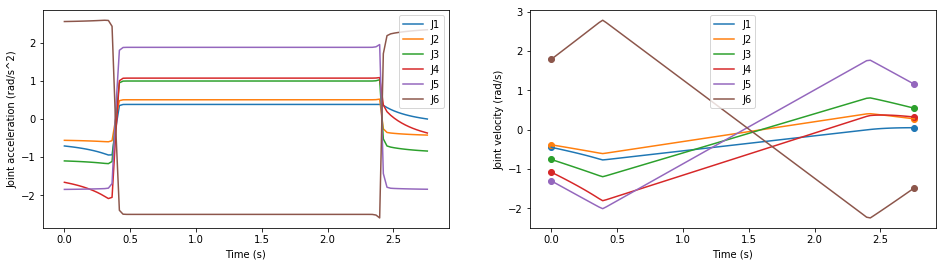

In [64]:
ts_sample = np.linspace(0, jnt_traj.get_duration(), 100)
qdds_sample = jnt_traj.evaldd(ts_sample)
qds_sample = jnt_traj.evald(ts_sample)

initial_velocities = path.evald(0) * 0.2
final_velocities = path.evald(path.duration) * 0.2
fig, axs = plt.subplots(1, 2, sharex=True, figsize=[16, 4])
for i in range(6):
    color = "C%d" % i
    axs[0].plot(ts_sample, qdds_sample[:, i], label="J{:d}".format(i + 1), c=color)
    axs[1].plot(ts_sample, qds_sample[:, i], label="J{:d}".format(i + 1), c=color)
    axs[1].scatter([0, jnt_traj.duration],
                   [initial_velocities[i], final_velocities[i]], c=color)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Joint acceleration (rad/s^2)")
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Joint velocity (rad/s)")
plt.show()
